# 卷积神经网络

## 图像分类

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

100%|██████████| 170498071/170498071 [02:01<00:00, 1398587.35it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified
训练集大小: 50000
测试集大小: 10000


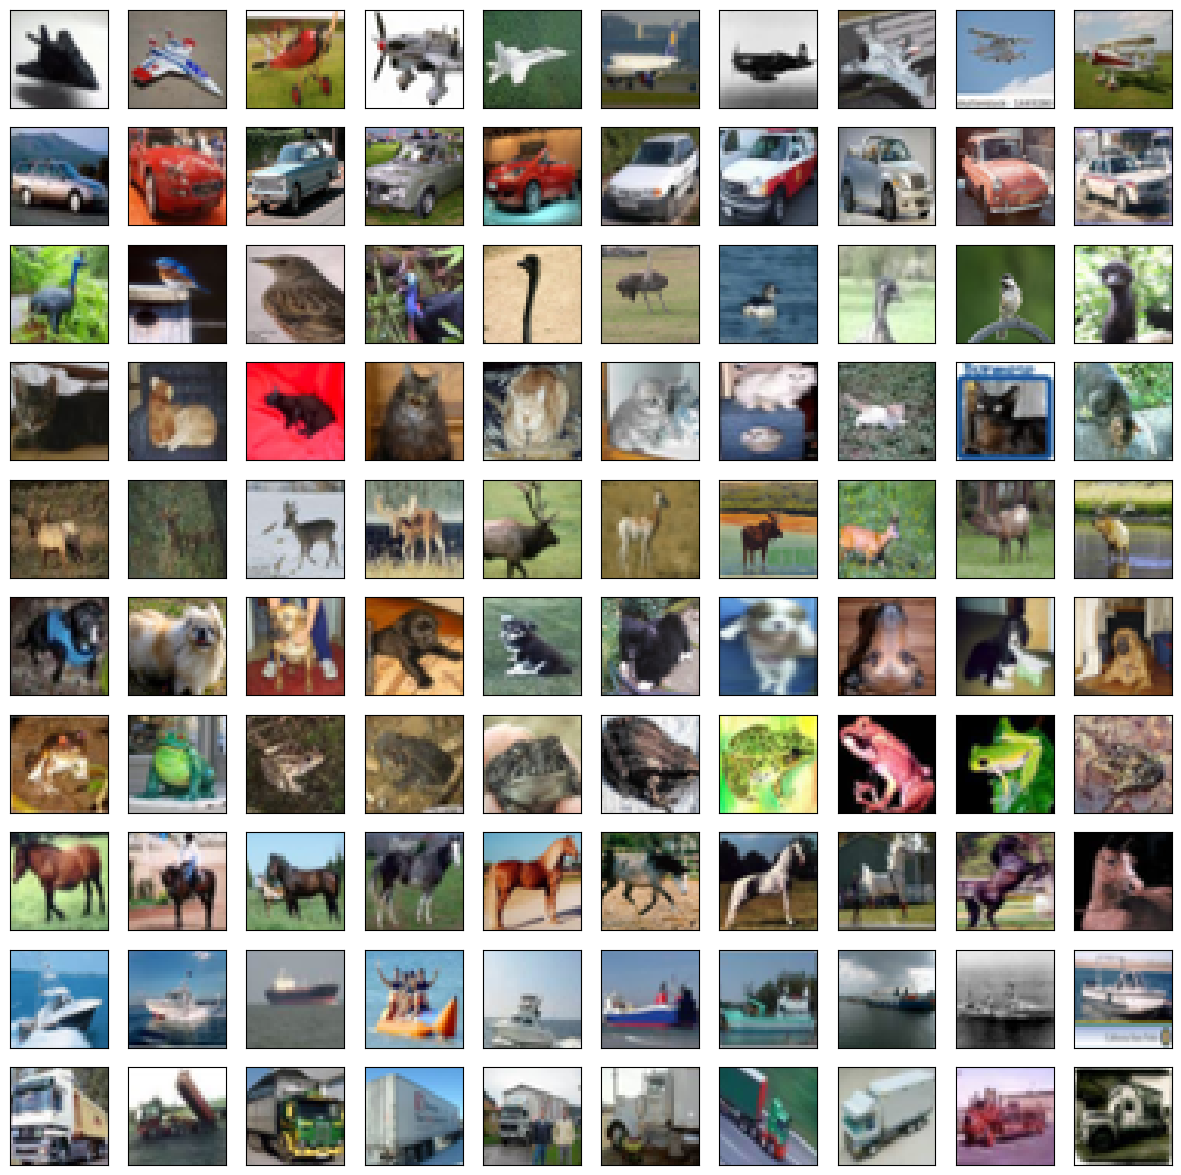

In [2]:
# 下载数据
data_path = './cifar10'
trainset = CIFAR10(root=data_path, train=True, download=True,
                   transform=transforms.ToTensor())
testset = CIFAR10(root=data_path, train=False, download=True,
                  transform=transforms.ToTensor())
print('训练集大小:', len(trainset))
print('测试集大小:', len(testset))

# 可视化数据
num_classes = 10
fig, axes = plt.subplots(num_classes, 10, figsize=(15, 15))
labels = np.array([t[1] for t in trainset])  # 获取所有标签
for i in range(num_classes):
    indice = np.where(labels == i)[0]  # 类别为i的索引
    for j in range(10):  # 每个类别取10张图片
        axes[i][j].imshow(trainset[indice[j]][0].permute(1, 2, 0).numpy())
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 类别数目
        self.num_classes = num_classes
        # Conv2D是二维卷积层，参数依次为：
        # in_channels: 输入通道
        # out_channels: 输出通道，即卷积核的数量
        # kernel_size: 卷积核大小，默认是正方形
        # padding:填充层数，padding1表示在图像周围填充一层0
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # 第二层卷积，输入通道与上一层的输出相同
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        # 最大池化
        self.pooling1 = nn.MaxPool2d(kernel_size=2)
        # 暂退，p表示每个位置被置为0的概率
        # 随机置退只在训练时开启，测试时应当关闭
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.pooling2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        # 全连接层
        self.fc1 = nn.Linear(4096, 512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    # 前向传播，将输入按顺序依次通过设置好的层
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pooling2(x)
        x = self.dropout2(x)

        # 全连接层之前将x的形状转换为（batch_size, n）
        x = x.view(len(x), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

In [7]:
batch_size = 64
lr = 1e-3
epochs = 5
np.random.seed(0)
torch.manual_seed(0)

In [8]:
# 批量生成器
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = F.cross_entropy

In [10]:
for epoch in range(epochs):
    losses = 0
    accs = 0
    num = 0
    model.train()  # 训练模式会开启dropout

    with tqdm(trainloader) as pbar:
        for data in pbar:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            num += len(labels)
            losses += loss.detach().numpy()*len(labels)
            accs += (torch.argmax(outputs, dim=-1) ==
                     labels).sum().detach().numpy()
            pbar.set_postfix({
                'Epoch': epoch,
                'Train loss': f'{losses/num:.3f}',
                'Train acc': f'{accs/num:.3f}'
            })

100%|██████████| 782/782 [01:50<00:00,  7.08it/s, Epoch=4, Train loss=0.871, Train acc=0.694]


In [11]:
losses = 0
accs = 0
num = 0
model.eval()  # 测试模式会关闭dropout

with tqdm(testloader) as pbar:
    for data in pbar:
        images, labels = data
        outputs = model(images)
        loss = criterion(outputs, labels)
        num += len(labels)
        losses += loss.detach().numpy()*len(labels)
        accs += (torch.argmax(outputs, dim=-1) ==
                 labels).sum().detach().numpy()
        pbar.set_postfix({
            'Epoch': epoch,
            'Test loss': f'{losses/num:.3f}',
            'Test acc': f'{accs/num:.3f}'
        })

100%|██████████| 157/157 [00:06<00:00, 23.50it/s, Epoch=4, Test loss=0.814, Test acc=0.714]


## 色彩风格迁移

In [1]:
from torchvision import models
import copy

In [4]:
# 定义图像处理方法
transform = transforms.Resize([512, 512])  # 规整图像大小

In [5]:
def loadimg(path):
    # 加载路径为path的图像，形状为H*W*c
    img = plt.imread(path)
    # 处理图像，注意重排维度是通道维在最前
    img = transform(torch.tensor(img).permute(2, 0, 1))
    # 展示图像
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()
    # 添加batch_size维度
    img = img.unsqueeze(0).to(dtype=torch.float32)
    img /= 255  # 将其值从0-255的整数转换为0-1的浮点数
    return img

In [8]:
content_image_path = os.path.join('style_transfer', 'content', '04.jpg')
style_image_path = os.path.join('style_transfer', 'style.jpg')

图像内容


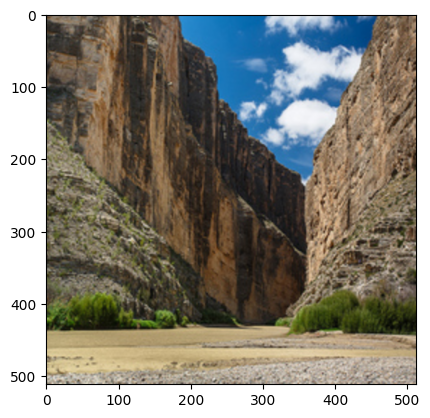

图像风格


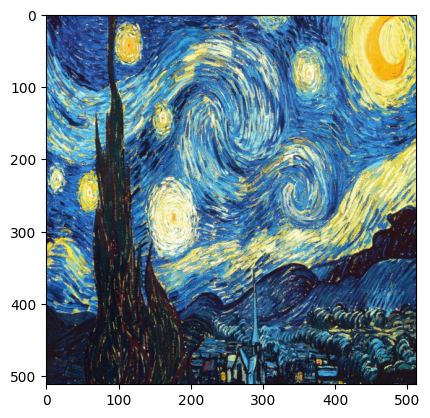

In [9]:
print('图像内容')
content_img = loadimg(content_image_path)
print('图像风格')
style_img = loadimg(style_image_path)

In [11]:
# 内容损失
class ContentLoss(nn.Module):
    def __init__(self, target):
        # target为从目标推向中提取的内容特征
        super().__init__()
        # 我们不对target求梯度，因此将target从梯度的计算途中分离出来
        self.target = target.detach()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # 利用MSE计算输入图像与目标内容图像之间的损失
        self.loss = self.criterion(x.clone(), self.target)
        return x  # 只计算损失，不改变输入

    def backward(self):
        # 本模块只包含损失计算，不改变输入，因此单独定义反向传播
        self.loss.backward(retain_graph=True)
        return self.loss

In [12]:
def gram(x):
    # 计算G矩阵
    batch_size, n, w, h = x.shape  # n为卷积核数目，w和h为输出的宽和高
    f = x.view(batch_size * n, w * h)  # 变换为二维
    g = f @ f.T / (batch_size * n * w * h)  # 除以参数数目进行归一化
    return g

In [13]:
# 风格损失
class StyleLoss(nn.Module):
    def __init__(self, target):
        # target为从目标图像中提取的风格特征
        # weight为设置的强度系数
        super().__init__()
        self.target_gram = gram(target.detach())  # 目标的格拉姆矩阵
        self.criterion = nn.MSELoss()

    def forward(self, x):
        import_gram = gram(x.clone())
        self.loss = self.criterion(import_gram, self.target_gram)
        return x

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [14]:
vgg16 = models.vgg16(weights=True).features  # 导入预训练的VGG16网络
# 选定用于提取特征的卷积层，Conv_13对应着第五块的第三个卷积层
content_layer = ['Conv_13']
# 下面这些层分别对应第一至第五的第一个卷积层
style_layer = ['Conv_1', 'Conv_3', 'Conv_5', 'Conv_8', 'Conv_11']

/opt/homebrew/Caskroom/miniforge/base/envs/homl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/wangxiao15/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:48<00:00, 11.3MB/s] 


In [15]:
content_losses = []
style_losses = []

model = nn.Sequential()  # 存储新模型的层
vgg16 = copy.deepcopy(vgg16)  # 复制VGG16网络
index = 1  # 计数卷积层

In [16]:
# 遍历vgg网络结构，选取需要的层
for layer in list(vgg16):
    if isinstance(layer, nn.Conv2d):
        name = "Conv_"+str(index)
        model.append(layer)
        if name in content_layer:
            # 如果当前层用于抽取内容特征，则添加内容损失
            target = model(content_img).clone()  # 计算内容图像的特征
            content_loss = ContentLoss(target)
            model.append(content_loss)
            content_losses.append(content_loss)

        if name in style_layer:
            # 如果当前层用于抽取风格特征，则添加风格损失
            target = model(style_img).clone()
            style_loss = StyleLoss(target)
            model.append(style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        # 如果是激活函数层
        model.append(layer)
        index += 1
    if isinstance(layer, nn.MaxPool2d):
        # 如果是最大池化层
        model.append(layer)

print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): StyleLoss(
    (criterion): MSELoss()
  )
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): StyleLoss(
    (criterion): MSELoss()
  )
  (8): ReLU(inplace=True)
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): StyleLoss(
    (criterion): MSELoss()
  )
  (14): ReLU(inplace=True)
  (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace=True)
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [17]:
epochs = 200
lr = 0.1
lbd = 1e6  # 风格损失的强度系数

input_img = content_img.clone()  # 从内容图像开始迁移
param = nn.Parameter(input_img.data)  # 将图像内容设置为可训练的参数
optimizer = torch.optim.Adam([param], lr=lr)

训练轮数：0,	风格损失:1042.2277,	内容损失：5.6380


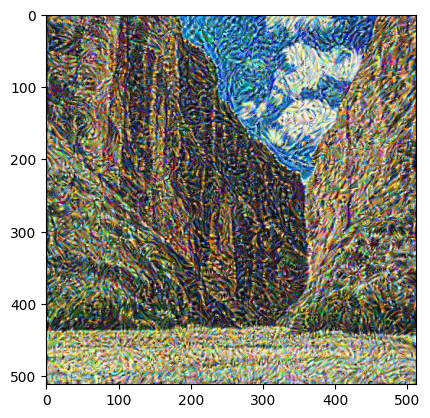

训练轮数：50,	风格损失:51.1869,	内容损失：3.3843


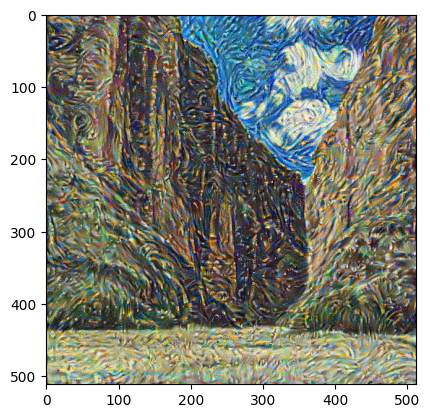

训练轮数：100,	风格损失:17.8236,	内容损失：2.6905


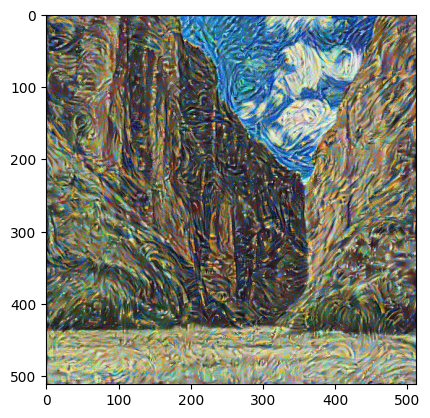

训练轮数：150,	风格损失:11.0873,	内容损失：2.3842


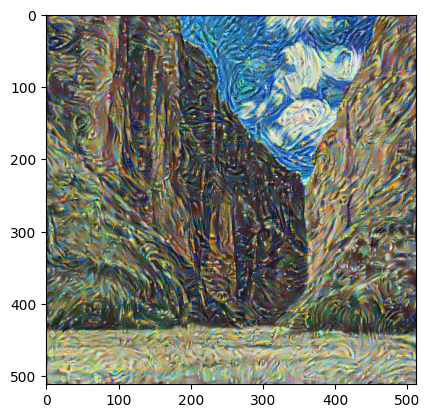

KeyboardInterrupt: 

In [19]:
for i in range(epochs):
    style_score = 0  # 本轮的风格损失
    content_score = 0  # 本轮的内容损失
    model(param)  # 将输入通过模型，得到损失
    for cl in content_losses:
        content_score += cl.backward()
    for sl in style_losses:
        style_score += sl.backward()

    style_score *= lbd
    loss = content_score + style_score

    # 更新输入图像
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 每次对输入图像进行更新后，图像中部分像素点会超出0-1的范围，因此需要进行裁剪
    param.data.clamp_(0, 1)

    if i % 50 == 0 or i == epochs - 1:
        print(f'训练轮数：{i},\t风格损失:{style_score.item():.4f},\t'
              f'内容损失：{content_score.item():.4f}')
        plt.imshow(input_img[0].permute(1, 2, 0).numpy())
        plt.show()